In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, load_diabetes, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

from kan import KAN

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
class KANDatasets:
    """Dataset utility class following PyKAN conventions"""

    @staticmethod
    def create_synthetic_dataset(n_samples=1000, n_features=2, noise=0.1, test_split=0.2, seed=42, device="auto"):
        """
        Create synthetic regression dataset in PyKAN format
        
        Returns:
            dict: {'train_input', 'train_label', 'test_input', 'test_label'}
        """

        device = device if device != "auto" else ("cuda" if torch.cuda.is_available() else "cpu")

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Generate data using sklearn
        X, y = make_regression(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=n_features,
            noise=noise,
            random_state=seed
        )
        
        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_split, random_state=seed
        )
        
        # Convert to PyKAN format (torch tensors)
        dataset = {
            'train_input': torch.tensor(X_train, dtype=torch.float32).to(device),
            'train_label': torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device),
            'test_input': torch.tensor(X_test, dtype=torch.float32).to(device),
            'test_label': torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
        }
        
        print(f"✅ Synthetic dataset created:")
        print(f"   Features: {n_features}, Samples: {n_samples}")
        print(f"   Train: {len(y_train)}, Test: {len(y_test)}")
        
        return dataset
    
    @staticmethod
    def create_diabetes_dataset(test_split=0.2, normalize=False, seed=42, device="auto"):
        """
        Load diabetes dataset in PyKAN format
        
        Diabetes dataset:
        - 442 samples, 10 features
        - Features: age, sex, body mass index, average blood pressure, 
                   6 serum measurements
        - Target: quantitative measure of disease progression one year after baseline
        """

        device = device if device != "auto" else ("cuda" if torch.cuda.is_available() else "cpu")

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Load sklearn diabetes dataset  
        X, y = load_diabetes(return_X_y=True)
        
        print(f"📊 Diabetes dataset info:")
        print(f"   Samples: {X.shape[0]}, Features: {X.shape[1]}")
        print(f"   Target range: [{y.min():.1f}, {y.max():.1f}]")
        print(f"   Target meaning: Disease progression after 1 year")
        
        # Optional normalization
        if normalize:
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            X = scaler_X.fit_transform(X)
            y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
            print(f"   ✅ Data normalized")
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_split, random_state=seed
        )
        
        # PyKAN format
        dataset = {
            'train_input': torch.tensor(X_train, dtype=torch.float32).to(device),
            'train_label': torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device),
            'test_input': torch.tensor(X_test, dtype=torch.float32).to(device),
            'test_label': torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
        }
        
        return dataset

    @staticmethod
    def create_polynomial_dataset(n_samples=300, degree=3, noise=0.1, test_split=0.2, seed=42, device="auto"):
        """
        Create 1D polynomial dataset: y = x + x^2 + x^3 + noise
        """

        device = device if device != "auto" else ("cuda" if torch.cuda.is_available() else "cpu")

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Generate x values
        x = np.linspace(-2, 2, n_samples)
        
        # Polynomial function: sum of powers
        y = np.zeros_like(x)
        for i in range(1, degree + 1):
            y += x**i
            
        # Add noise
        y += np.random.normal(0, noise, x.shape)
        
        # Reshape for PyKAN (samples, features)
        X = x.reshape(-1, 1)  # 1D input
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_split, random_state=seed
        )
        
        dataset = {
            'train_input': torch.tensor(X_train, dtype=torch.float32).to(device),
            'train_label': torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device),
            'test_input': torch.tensor(X_test, dtype=torch.float32).to(device),
            'test_label': torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
        }
        
        print(f"🔢 Polynomial dataset (degree {degree}) created:")
        print(f"   Formula: y = x + x² + x³ + ... + x^{degree} + noise")
        print(f"   Samples: {n_samples}, Train: {len(y_train)}, Test: {len(y_test)}")
        
        return dataset
    
    @staticmethod
    def create_sinusoidal_dataset(n_samples=300, frequency=2, amplitude=1, noise=0.1, test_split=0.2, seed=42, device="auto"):
        """
        Create sinusoidal dataset: y = amplitude * sin(frequency * π * x) + noise
        """

        device = device if device != "auto" else ("cuda" if torch.cuda.is_available() else "cpu")

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        x = np.linspace(-2, 2, n_samples)
        y = amplitude * np.sin(frequency * np.pi * x) + np.random.normal(0, noise, x.shape)
        
        X = x.reshape(-1, 1)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_split, random_state=seed
        )
        
        dataset = {
            'train_input': torch.tensor(X_train, dtype=torch.float32).to(device),
            'train_label': torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device),
            'test_input': torch.tensor(X_test, dtype=torch.float32).to(device),
            'test_label': torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
        }
        
        print(f"🌊 Sinusoidal dataset created:")
        print(f"   Formula: y = {amplitude} * sin({frequency}π * x) + noise")
        print(f"   Samples: {n_samples}, Train: {len(y_train)}, Test: {len(y_test)}")
        
        return dataset
    
    @staticmethod
    def create_complex_2d_dataset(n_samples=1000, test_split=0.2, seed=42, device="auto"):
        """
        Complex 2D function from PyKAN tutorials: f(x,y) = exp(sin(πx) + y²)
        """

        device = device if device != "auto" else ("cuda" if torch.cuda.is_available() else "cpu")

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Generate random 2D input in [-1, 1]
        X = np.random.uniform(-1, 1, (n_samples, 2))
        
        # Complex function: exp(sin(π*x) + y²)
        y = np.exp(np.sin(np.pi * X[:, 0]) + X[:, 1]**2)
        
        # Add noise
        y += np.random.normal(0, 0.1, y.shape)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_split, random_state=seed
        )
        
        dataset = {
            'train_input': torch.tensor(X_train, dtype=torch.float32).to(device),
            'train_label': torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device),
            'test_input': torch.tensor(X_test, dtype=torch.float32).to(device),
            'test_label': torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
        }
        
        print(f"🧮 Complex 2D dataset created:")
        print(f"   Formula: y = exp(sin(πx₁) + x₂²) + noise")
        print(f"   Samples: {n_samples}, Train: {len(y_train)}, Test: {len(y_test)}")
        
        return dataset

# Test all datasets
print("=" * 50)
print("TESTING ALL DATASETS")
print("=" * 50)

# Test każdego datasetu
datasets = {
    'synthetic': KANDatasets.create_synthetic_dataset(n_samples=500, n_features=3),
    'diabetes': KANDatasets.create_diabetes_dataset(),
    'polynomial': KANDatasets.create_polynomial_dataset(degree=3),
    'sinusoidal': KANDatasets.create_sinusoidal_dataset(),
    'complex_2d': KANDatasets.create_complex_2d_dataset()
}

print(datasets['diabetes']['train_input'][:5])

print(f"\n📋 DATASET SUMMARY:")
for name, dataset in datasets.items():
    train_samples = dataset['train_input'].shape[0]
    test_samples = dataset['test_input'].shape[0]
    n_features = dataset['train_input'].shape[1]
    
    print(f"  {name}:")
    print(f"    Input shape: ({train_samples}+{test_samples}, {n_features})")
    print(f"    Label range: [{dataset['train_label'].min():.2f}, {dataset['train_label'].max():.2f}]")

TESTING ALL DATASETS
✅ Synthetic dataset created:
   Features: 3, Samples: 500
   Train: 400, Test: 100
📊 Diabetes dataset info:
   Samples: 442, Features: 10
   Target range: [25.0, 346.0]
   Target meaning: Disease progression after 1 year
🔢 Polynomial dataset (degree 3) created:
   Formula: y = x + x² + x³ + ... + x^3 + noise
   Samples: 300, Train: 240, Test: 60
🌊 Sinusoidal dataset created:
   Formula: y = 1 * sin(2π * x) + noise
   Samples: 300, Train: 240, Test: 60
🧮 Complex 2D dataset created:
   Formula: y = exp(sin(πx₁) + x₂²) + noise
   Samples: 1000, Train: 800, Test: 200
tensor([[ 0.0708,  0.0507,  0.0121,  0.0563,  0.0342,  0.0494, -0.0397,  0.0343,
          0.0274, -0.0011],
        [-0.0091,  0.0507, -0.0181, -0.0332, -0.0208,  0.0122, -0.0729,  0.0712,
          0.0003,  0.0196],
        [ 0.0054, -0.0446,  0.0498,  0.0976, -0.0153, -0.0163, -0.0066, -0.0026,
          0.0170, -0.0135],
        [-0.0273, -0.0446, -0.0353, -0.0298, -0.0566, -0.0586,  0.0302, -0.0395,
 

In [4]:
# 1D array - x.ndim == 1
x_1d = np.array([1, 2, 3, 4])
print(type(x_1d))
print(f"1D: shape={x_1d.shape}, ndim={x_1d.ndim}")

# 2D array z 1 kolumną - x.shape[1] == 1  
x_2d_single = np.array([[1], [2], [3], [4]])
print(f"2D single col: shape={x_2d_single.shape}, ndim={x_2d_single.ndim}")

# 2D array z wieloma kolumnami - else case
x_2d_multi = np.array([[1, 2], [3, 4], [5, 6]])
print(f"2D multi col: shape={x_2d_multi.shape}, ndim={x_2d_multi.ndim}")

# 3D+ dane będą miały x.ndim > 2, więc trafią do else
x_3d = np.random.rand(10, 5, 3)
print(f"3D: shape={x_3d.shape}, ndim={x_3d.ndim}")

<class 'numpy.ndarray'>
1D: shape=(4,), ndim=1
2D single col: shape=(4, 1), ndim=2
2D multi col: shape=(3, 2), ndim=2
3D: shape=(10, 5, 3), ndim=3


In [5]:
X_1d = np.linspace(-2, 2, 300).reshape(-1, 1)
print(X_1d.shape)

(300, 1)


In [6]:
class KANRegressor:
    """KAN wrapper for regression tasks using native PyKAN fit()"""

    def __init__(self, width=[2, 5, 1], grid=5, k=3, seed=0, device="auto"):
        self.width = width
        self.grid = grid  
        self.k = k
        self.seed = seed
        self.device = device if device != "auto" else ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.is_trained = False
        
        print(f"🚀 KAN initialized: {width}, device: {self.device}")
    
    def fit(self, dataset, opt="LBFGS", steps=50, lamb=0.001, lamb_entropy=2.0):
        """
        Train KAN model using PyKAN dataset format
        
        Args:
            dataset: Dict with keys ['train_input', 'train_label', 'test_input', 'test_label']
        """
        # Auto-adjust input dimension
        input_dim = dataset['train_input'].shape[1]
        if self.width[0] != input_dim:
            self.width[0] = input_dim
            print(f"📏 Auto-adjusted input dimension to {input_dim}")
        
        # Create model
        self.model = KAN(width=self.width, grid=self.grid, k=self.k, seed=self.seed, device=self.device)
        
        print(f"🏋️ Training KAN with {opt} for {steps} steps...")
        
        # Train using native PyKAN fit()
        self.results = self.model.fit(
            dataset, 
            opt=opt, 
            steps=steps, 
            lamb=lamb,
            lamb_entropy=lamb_entropy
        )
        
        self.is_trained = True
        print(f"✅ Training completed!")
        
        # Print final losses
        if hasattr(self.results, 'train_loss'):
            train_loss = self.results.train_loss[-1] 
            test_loss = self.results.test_loss[-1] if hasattr(self.results, 'test_loss') else 0
            print(f"📊 Final losses - Train: {train_loss:.4f}, Test: {test_loss:.4f}")
    
    def predict(self, X):
        """Make predictions"""
        if not self.is_trained:
            raise ValueError("Model not trained yet!")
            
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)
            
        X = X.to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X)
            
        return predictions.cpu().numpy()
    
    def plot_training(self):
        """Plot training history"""
        if not hasattr(self, 'results'):
            print("No training results to plot")
            return
            
        plt.figure(figsize=(10, 4))
        
        
        # Sprawdź czy results to słownik czy obiekt
        if isinstance(self.results, dict):
            # Słownik - użyj kluczy
            if 'train_loss' in self.results:
                train_loss = self.results['train_loss']
                plt.plot(train_loss, label='Train Loss')
            if 'test_loss' in self.results:
                test_loss = self.results['test_loss'] 
                plt.plot(test_loss, label='Test Loss')
        else:
            # Obiekt - użyj atrybutów
            if hasattr(self.results, 'train_loss'):
                plt.plot(self.results.train_loss, label='Train Loss')
            if hasattr(self.results, 'test_loss'):
                plt.plot(self.results.test_loss, label='Test Loss')
        
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training History')
        plt.grid(True)
        
        self.model.plot()
            
        plt.show()

print("✅ SimpleKANRegressor created following PyKAN conventions!")

✅ SimpleKANRegressor created following PyKAN conventions!


🧪 PRACTICAL TEST OF NEW IMPLEMENTATION
🔢 Polynomial dataset (degree 3) created:
   Formula: y = x + x² + x³ + ... + x^3 + noise
   Samples: 400, Train: 320, Test: 80
🚀 KAN initialized: [1, 4, 2, 1], device: cuda
checkpoint directory created: ./model
saving model version 0.0
🏋️ Training KAN with LBFGS for 30 steps...


| train_loss: 9.15e-02 | test_loss: 1.09e-01 | reg: 1.38e+01 | : 100%|█| 30/30 [00:15<00:00,  1.88it


saving model version 0.1
✅ Training completed!

📈 Results:
   MSE: 0.0118


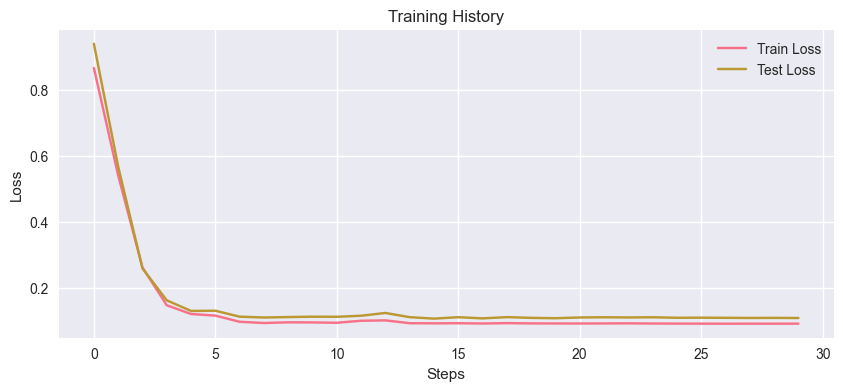

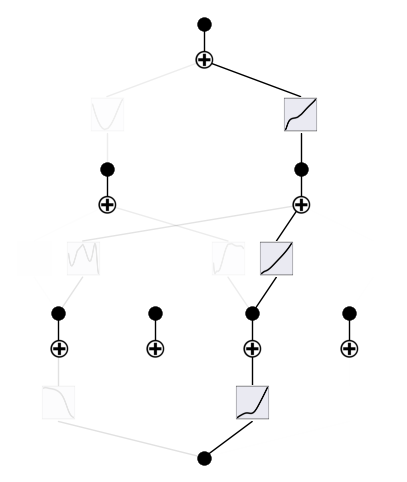


🔄 Testing with diabetes dataset...
📊 Diabetes dataset info:
   Samples: 442, Features: 10
   Target range: [25.0, 346.0]
   Target meaning: Disease progression after 1 year
🚀 KAN initialized: [10, 5, 4, 1], device: cpu
checkpoint directory created: ./model
saving model version 0.0
🏋️ Training KAN with LBFGS for 30 steps...


| train_loss: 3.10e+01 | test_loss: 9.58e+01 | reg: 8.37e+02 | : 100%|█| 30/30 [00:11<00:00,  2.66it


saving model version 0.1
✅ Training completed!


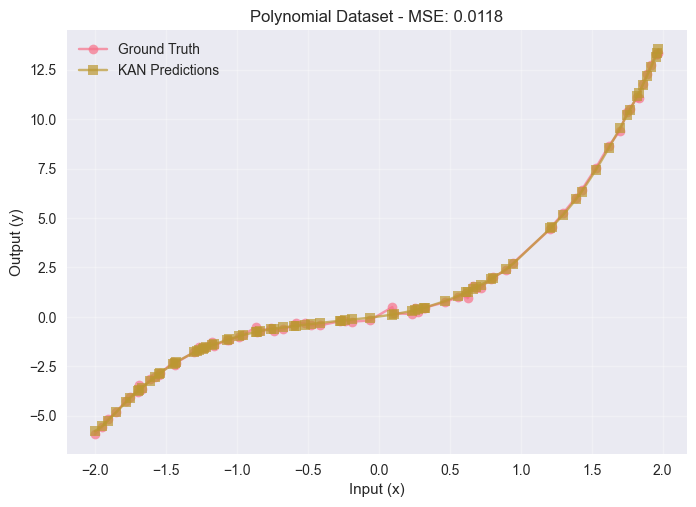

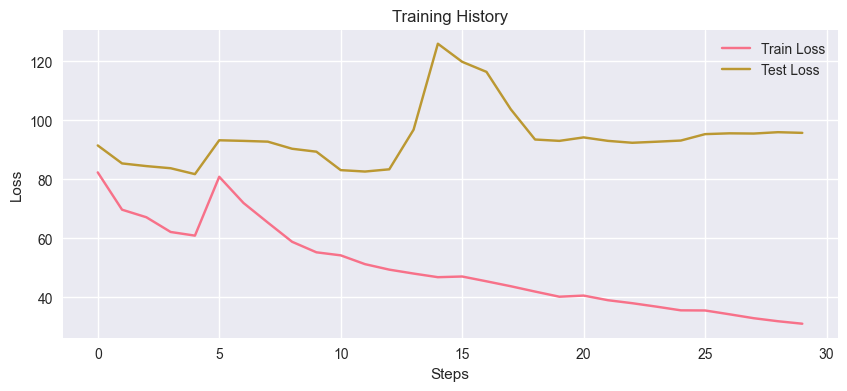

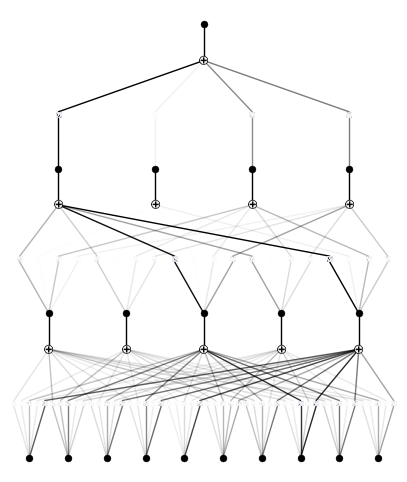

In [12]:
# PRAKTYCZNY TEST - JAK UŻYWAĆ

print("🧪 PRACTICAL TEST OF NEW IMPLEMENTATION")
print("=" * 50)

# 1. Create dataset
dataset = KANDatasets.create_polynomial_dataset(n_samples=400, degree=3)

# 2. Create and train KAN
kan = KANRegressor(width=[1, 4, 2, 1], grid=5, k=4)
kan.fit(dataset, steps=30, lamb_entropy=2.0, lamb=0.001)

# 3. Test predictions
test_input = dataset['test_input']
predictions = kan.predict(test_input)

# 4. Evaluate
from sklearn.metrics import mean_squared_error, r2_score

test_labels = dataset['test_label'].cpu()
mse = mean_squared_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

print(f"\n📈 Results:")
print(f"   MSE: {mse:.4f}")
# print(f"   R²: {r2:.4f}")

# 5. Plot training history
kan.plot_training()

x_values = test_input.cpu().numpy().flatten()
y_true = test_labels.flatten()
y_pred = predictions.flatten()

# Sort by x for better line plot
sort_idx = np.argsort(x_values)
x_sorted = x_values[sort_idx]
y_true_sorted = y_true[sort_idx]
y_pred_sorted = y_pred[sort_idx]

plt.plot(x_sorted, y_true_sorted, 'o-', label='Ground Truth', alpha=0.7)
plt.plot(x_sorted, y_pred_sorted, 's-', label='KAN Predictions', alpha=0.7)
plt.xlabel('Input (x)')
plt.ylabel('Output (y)')
plt.title(f'Polynomial Dataset - MSE: {mse:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Test with different dataset
print(f"\n🔄 Testing with diabetes dataset...")
diabetes_data = KANDatasets.create_diabetes_dataset(device='cpu')
kan_diabetes = KANRegressor(width=[10, 5, 4, 1], device='cpu')  # 10 features
kan_diabetes.fit(diabetes_data, steps=30, lamb_entropy=2.0, lamb=0.001)

kan_diabetes.plot_training()

In [ ]:
# Test czy PyKAN sam przenosi dane
model = KAN(width=[2, 5, 1], device="cuda")

# Dataset na CPU
dataset = {
    'train_input': torch.randn(100, 2, dtype=torch.float32),    # CPU
    'train_label': torch.randn(100, dtype=torch.float32)        # CPU
}

print(f"Dataset device: {dataset['train_input'].device}")      # cpu
print(f"Model device: {next(model.parameters()).device}")      # cuda

# PyKAN prawdopodobnie SAM przenosi dane wewnętrznie w fit()
# Ale lepiej być pewnym i zrobić to explicite

# Test z przykładowymi danymi
X_test = torch.randn(10, 2)
dataset_test = {
    'train_input': torch.tensor(X_test, dtype=torch.float32)
}
print(f"Test tensor device: {dataset_test['train_input'].device}")

checkpoint directory created: ./model
saving model version 0.0
Dataset device: cpu
Model device: cuda:0
Test tensor device: cpu


In [ ]:
# Dodaj to do swojego notebooka:

print("=== COMPLETE DEVICE TEST ===")

# 1. Sprawdź dostępne GPU
if torch.cuda.is_available():
    print(f"GPU count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available")

# 2. Test czy PyKAN przenosi dane
model = KAN(width=[2, 5, 1], device="cuda")
print(f"\nModel device: {next(model.parameters()).device}")

# 3. Dataset na CPU
dataset = {
    'train_input': torch.randn(1000, 2, dtype=torch.float32).cuda(),
    'train_label': torch.randn(1000, dtype=torch.float32).cuda(),
    'test_input': torch.randn(1000, 2, dtype=torch.float32).cuda(),
    'test_label': torch.randn(1000, dtype=torch.float32).cuda()
}
print(f"Dataset before fit: {dataset['train_input'].device}")

# 4. Test real fit (jeśli chcesz sprawdzić czy działa)
# try:
results = model.fit(dataset, opt="LBFGS", steps=10)  # Tylko 1 step
#     print("✅ PyKAN successfully handled CPU→GPU transfer!")
# except Exception as e:
#     print(f"❌ Error: {e}")
if torch.cuda.is_available():
    print(f"GPU Memory before training:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"  Reserved: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")
        

=== COMPLETE DEVICE TEST ===
GPU count: 1
  GPU 0: NVIDIA RTX A1000 Laptop GPU
checkpoint directory created: ./model
saving model version 0.0

Model device: cuda:0
Dataset before fit: cuda:0



















| train_loss: 9.59e-01 | test_loss: 1.03e+00 | reg: 6.83e+00 | : 100%|█| 10/10 [00:01<00:00,  9.11it

saving model version 0.1
GPU Memory before training:
  Allocated: 18.1 MB
  Reserved: 66.0 MB


In [ ]:
import torch
import torch.nn as nn

model = nn.Linear(10, 5)
model.parameters()
# Metoda 1: next() - NAJSZYBSZA
device1 = next(model.parameters())
print(f"next(): {device1}")

# Metoda 2: Lista wszystkich parametrów - WOLNIEJSZA
device2 = list(model.parameters())
print(f"list()[0]: {device2}")

# Metoda 3: Iteracja - NIEPOTRZEBNIE DŁUGA
for param in model.parameters():
    device3 = param.device
    break
print(f"for loop: {device3}")

# Metoda 4: PyTorch sposób (nowsze wersje)
try:
    device4 = model.device  # Nie wszystkie modele mają ten atrybut
    print(f"model.device: {device4}")
except AttributeError:
    print("model.device not available")

next(): Parameter containing:
tensor([[-0.1061, -0.0468,  0.0035,  0.2608,  0.0395,  0.2832,  0.1934, -0.1999,
          0.1418, -0.2235],
        [-0.1340,  0.0930,  0.1044,  0.2372, -0.1018,  0.0005,  0.1628, -0.3058,
          0.2286, -0.2615],
        [ 0.0044, -0.0538, -0.1665,  0.0418,  0.2615, -0.0924, -0.1877, -0.1170,
         -0.3134,  0.1427],
        [-0.1519, -0.2110, -0.1822,  0.1818,  0.1675,  0.2427,  0.1147, -0.1056,
         -0.0884,  0.0934],
        [ 0.2600,  0.0860, -0.1496, -0.1487, -0.2990,  0.0683, -0.1775, -0.2819,
          0.2773, -0.2054]], requires_grad=True)
list()[0]: [Parameter containing:
tensor([[-0.1061, -0.0468,  0.0035,  0.2608,  0.0395,  0.2832,  0.1934, -0.1999,
          0.1418, -0.2235],
        [-0.1340,  0.0930,  0.1044,  0.2372, -0.1018,  0.0005,  0.1628, -0.3058,
          0.2286, -0.2615],
        [ 0.0044, -0.0538, -0.1665,  0.0418,  0.2615, -0.0924, -0.1877, -0.1170,
         -0.3134,  0.1427],
        [-0.1519, -0.2110, -0.1822,  0.1818

In [ ]:
import torch
import torch.nn as nn

model = nn.Linear(3, 2)

print("=== Krok po kroku ===")

# 1. model.parameters() tworzy generator
params_generator = model.parameters()
print(f"Generator: {params_generator}")

# 2. next() pobiera pierwszy element z generatora
first_param = next(params_generator)
print(f"First parameter: {first_param}")
print(f"Shape: {first_param.shape}")  # [2, 3] - wagi warstwy Linear
print(f"Device: {first_param.device}")

# 3. Drugi next() dałby bias
second_param = next(params_generator)
print(f"Second parameter (bias): {second_param}")
print(f"Shape: {second_param.shape}")  # [2] - bias

# 4. Trzeci next() - już nie ma więcej parametrów
try:
    third_param = next(params_generator)
except StopIteration:
    print("No more parameters - StopIteration raised")

=== Krok po kroku ===
Generator: <generator object Module.parameters at 0x000002CF721E4740>
First parameter: Parameter containing:
tensor([[-0.3399,  0.1076, -0.4476],
        [-0.4002, -0.2982,  0.2612]], requires_grad=True)
Shape: torch.Size([2, 3])
Device: cpu
Second parameter (bias): Parameter containing:
tensor([ 0.2322, -0.3420], requires_grad=True)
Shape: torch.Size([2])
No more parameters - StopIteration raised


🌊 Sinusoidal dataset created:
   Formula: y = 1 * sin(2π * x) + noise
   Samples: 300, Train: 240, Test: 60
🚀 KAN initialized: [1, 3, 1], device: cuda
checkpoint directory created: ./model
saving model version 0.0
🏋️ Training KAN with LBFGS for 5 steps...


| train_loss: 7.63e-02 | test_loss: 7.95e-02 | reg: 1.14e+01 | : 100%|█| 5/5 [00:01<00:00,  2.78it/s


saving model version 0.1
✅ Training completed!


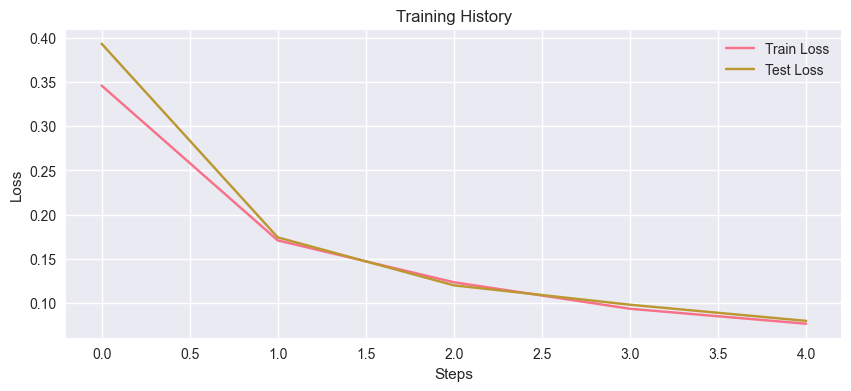

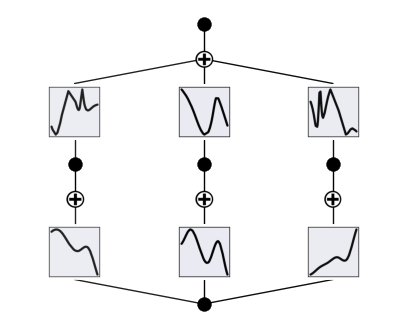

(300, 1) <class 'numpy.ndarray'>


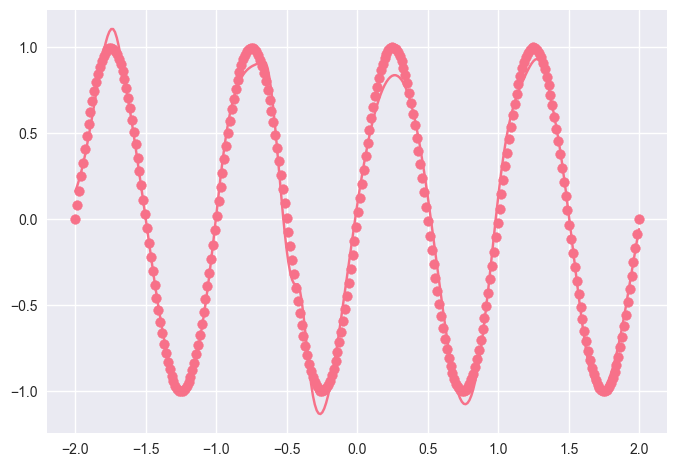

In [42]:
dataset = KANDatasets.create_sinusoidal_dataset(noise=0.0)

model = KANRegressor(width=[1, 3, 1])
model.fit(dataset, steps=5)

model.plot_training()

test_input = dataset['test_input'].cpu().detach().numpy()
test_labels = dataset['test_label'].cpu().detach().numpy()
predictions = model.predict(test_input)

x_values = test_input.flatten()
y_true = test_labels.flatten()
y_pred = predictions.flatten()

sorted_idx = np.argsort(x_values)
x_values = x_values[sorted_idx]
y_true = y_true[sorted_idx]
y_pred = y_pred[sorted_idx]

all_input = torch.cat([dataset['test_input'], dataset['train_input']], dim=0).cpu().detach().numpy()
all_labels = torch.cat([dataset['test_label'], dataset['train_label']], dim=0).cpu().detach().numpy()
all_predictions = model.predict(all_input)

print(all_predictions.shape, type(all_predictions))

x_values = all_input.flatten()
y_true = all_labels.flatten()
y_pred = all_predictions.flatten()

sorted_idx = np.argsort(x_values)
x_sorted = x_values[sorted_idx]
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]

mse = mean_squared_error(y_true, y_pred)

plt.plot(x_sorted, y_pred_sorted)
plt.scatter(x_sorted, y_true_sorted)



In [49]:
def get_complete_dataset_predictions(dataset: dict[str, torch.Tensor], model: KANRegressor) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Get combined train+test data with predictions for visualization"""
    all_input = torch.cat([dataset['train_input'], dataset['test_input']], dim=0).cpu().detach().numpy()
    all_labels = torch.cat([dataset['train_label'], dataset['test_label']], dim=0).cpu().detach().numpy()
    all_predictions: torch.Tensor = model.predict(all_input)

    x_values = all_input.flatten()
    y_true = all_labels.flatten()
    y_pred = all_predictions.flatten()

    sorted_idx = np.argsort(x_values)
    x_values = x_values[sorted_idx]
    y_true = y_true[sorted_idx]
    y_pred = y_pred[sorted_idx]

    return x_values, y_true, y_pred


In [46]:
# dataset = KANDatasets.create_sinusoidal_dataset(noise=0.0)
print(type(test_input))
print(all_predictions[:3].flatten(), all_predictions.flatten().shape)
print(all_predictions[:3], all_predictions.shape)

<class 'numpy.ndarray'>
[-1.0097744  -0.36199945  0.2552021 ] (300,)
[[-1.0097744 ]
 [-0.36199945]
 [ 0.2552021 ]] (300, 1)


In [50]:

import tensorflow as tf, torch
print("TF:", tf.__version__)
print("TF GPUs:", tf.config.list_physical_devices('GPU'))
print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())


TF: 2.12.0
TF GPUs: []
Torch: 2.5.1+cu121 CUDA available: True


In [ ]:
from sklearn.neural_network import MLPRegressor as SklearnMLP

class SimpleMLP:
    def __init__(self, hidden_layer_sizes=(32, 16), activation='tanh', max_iter=1000, random_state=42):
        self.model = SklearnMLP(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            max_iter=max_iter,
            random_state=random_state,
            early_stopping=True,
            validation_fraction=0.2,
            verbose=True,  # Wbudowane printowanie statusu treningu!
            n_iter_no_change=20
        )
        
    def fit(self, X, y):
        if hasattr(X, 'cpu'):
            X = X.cpu().numpy()
        if hasattr(y, 'cpu'):
            y = y.cpu().numpy().ravel()
        
        print("🏋️ Training MLP with sklearn...")
        self.model.fit(X, y)
        print("✅ Training completed!")
        return self
    
    def predict(self, X):
        if hasattr(X, 'cpu'):
            X = X.cpu().numpy()
        return self.model.predict(X)
    
    def plot_loss(self):
        if hasattr(self.model, 'loss_curve_'):
            plt.figure(figsize=(8, 4))
            plt.plot(self.model.loss_curve_, 'o-', label='Training Loss', alpha=0.8)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('MLP Training Progress')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.yscale('log')
            plt.show()
            print(f"Final loss: {self.model.loss_curve_[-1]:.6f}")

🌊 Sinusoidal dataset created:
   Formula: y = 1 * sin(2π * x) + noise
   Samples: 300, Train: 240, Test: 60
Dane podzielone na batche:
  Train batches: 15 (po 16 przykładów)
  Val batches: 4 (po 16 przykładów)
Epoch   0: Train Loss: 0.517952, Val Loss: 0.475645
Epoch  50: Train Loss: 0.161808, Val Loss: 0.213339
Epoch  50: Train Loss: 0.161808, Val Loss: 0.213339
Epoch  94: Train Loss: 0.030534, Val Loss: 0.029794
Early stopping at epoch 94
Epoch  94: Train Loss: 0.030534, Val Loss: 0.029794
Early stopping at epoch 94


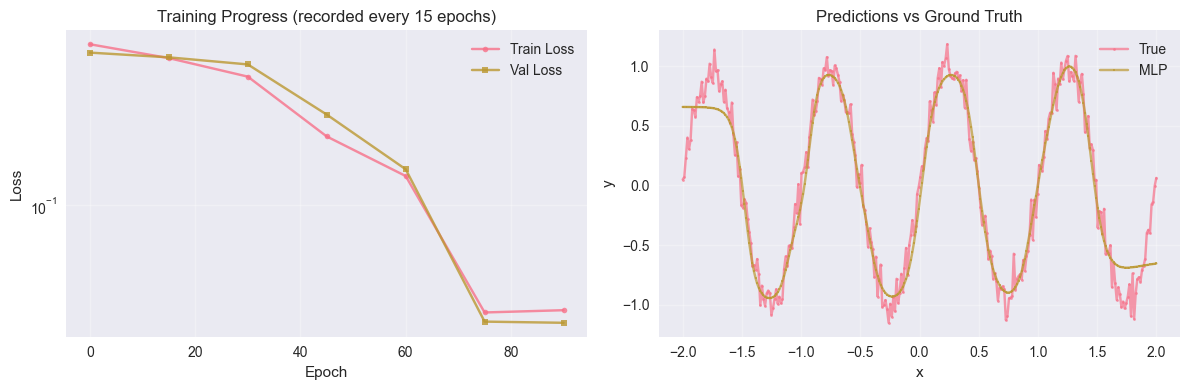

MLP Results: MSE: 0.028663, R²: 0.9376
Recorded 7 points instead of 300


In [ ]:
# Prosty test MLP używając sklearn z wbudowanym verbose
dataset = KANDatasets.create_sinusoidal_dataset(n_samples=300, noise=0.1, device='cpu')

# Połącz train+test dla sklearn (nie używa batchy)
all_input = torch.cat([dataset['train_input'], dataset['test_input']], dim=0)
all_labels = torch.cat([dataset['train_label'], dataset['test_label']], dim=0)

# Trenuj MLP z automatycznym printowaniem
mlp = SimpleMLP(hidden_layer_sizes=(32, 16), max_iter=1000)
mlp.fit(dataset['train_input'], dataset['train_label'])

# Plot loss curve
mlp.plot_loss()

# Predykcje i ewaluacja
mlp_predictions = mlp.predict(all_input)

# Sort for plotting
x_vals = all_input.numpy().flatten()
y_true = all_labels.numpy().flatten()
y_pred = mlp_predictions.flatten()
sort_idx = np.argsort(x_vals)

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(x_vals[sort_idx], y_true[sort_idx], 'o-', label='True', alpha=0.7, markersize=2)
plt.plot(x_vals[sort_idx], y_pred[sort_idx], 's-', label='MLP', alpha=0.7, markersize=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('MLP Predictions vs Ground Truth')
plt.show()

# Evaluate
test_pred = mlp.predict(dataset['test_input'])
test_true = dataset['test_label'].numpy()
mse = mean_squared_error(test_true, test_pred)
r2 = r2_score(test_true, test_pred)
print(f"MLP Results: MSE: {mse:.6f}, R²: {r2:.4f}")